# Pure Thermal Advection

Romain Beucher, Peter Lovely

This example illustrates the use of the Semi-Lagrangian Crank-Nicholson advection-diffusion method in a case of pure thermal advection.

A column of material representing the lithosphere is extended. The material is advected vertically. 

We visually track the isotherm which corresponds to the interface between the crust and the mantle
Diffusivity of the materials is set to be negligible so that the thermal field is advected with the material.
The isotherm remains at the interface.

In [1]:
import UWGeodynamics as GEO
from UWGeodynamics import visualisation as vis

loaded rc file /opt/UWGeodynamics/UWGeodynamics/uwgeo-data/uwgeodynamicsrc


In [2]:
u = GEO.UnitRegistry

## Scaling

In [3]:
half_rate = 1.8 * u.centimeter / u.year
model_height = 120. * u.km
surfaceTemp = 273.15 * u.degK
baseModelTemp = 1603.15 * u.degK
bodyforce = 3300 * u.kilogram / u.metre**3 * 9.81 * u.meter / u.second**2

KL = model_height
Kt = KL / half_rate
KM = bodyforce * KL**2 * Kt**2
KT = (baseModelTemp - surfaceTemp)

GEO.scaling_coefficients["[length]"] = KL
GEO.scaling_coefficients["[time]"] = Kt
GEO.scaling_coefficients["[mass]"]= KM
GEO.scaling_coefficients["[temperature]"] = KT

# Geometry
 

In [4]:
Model = GEO.Model(elementRes=(8, 64), 
                  minCoord=(0. * u.kilometer, -110. * u.kilometer), 
                  maxCoord=(15. * u.kilometer, 10. * u.kilometer), 
                  gravity=(0.0, -9.81 * u.meter / u.second**2))

## Set diffusivity to be negligible

In [5]:
Model.diffusivity = 1e-7 * u.metre**2 / u.second 
Model.capacity    = 1200. * u.joule / (u.kelvin * u.kilogram)

In [6]:
conductivity = Model.diffusivity * Model.capacity * 3200 * u.kilogram / u.metre**3

In [7]:
conductivity.to(u.watt / u.m / u.kelvin)

0.38399999999999995 <Unit('watt / kelvin / meter')>

# Add some Materials

In [8]:
air = Model.add_material(name="Air", shape=GEO.shapes.Layer(top=Model.top, bottom=0.0 * u.kilometer))
uppercrust = Model.add_material(name="UpperCrust", shape=GEO.shapes.Layer(top=air.bottom, bottom=-35.0*u.kilometer))
mantle=Model.add_material(name="Mantle", shape=GEO.shapes.Layer(top=uppercrust.bottom, bottom=-105.0 * u.kilometer))
asthenosphere=Model.add_material(name="Asthenosphere", shape=GEO.shapes.Layer(top=mantle.bottom, bottom=Model.bottom))

Note, add beta to the density property definition if you wish to incorporate pressure dependency

In [9]:
air.density = 1. * u.kilogram / u.metre**3
uppercrust.density = 2750. * u.kilogram / u.metre**3
mantle.density=3300. * u.kilogram / u.meter**3
asthenosphere.density=3300. * u.kilogram / u.meter**3

# Passive Tracers

In [10]:
import numpy as np

x = np.linspace(Model.minCoord[0], Model.maxCoord[0], 100) * u.kilometer
interface1 = GEO.nd(uppercrust.top)
interface2 = GEO.nd(mantle.top)

interface1 = Model.add_passive_tracers(name="Interface1", vertices=[x, interface1])
interface2 = Model.add_passive_tracers(name="Interface2", vertices=[x, interface2])

/usr/local/lib/python3.5/dist-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)


# Define Viscosities

The rheology library contains some commonly used rheologies stored in a python dictionary structure. We can list the keys defining the rheologies as follows:

Viscosities are defined below.  the multipliers are applied to the entire power-law.  

In [11]:
air.viscosity                = 1e19 * u.pascal * u.second
uppercrust.viscosity         = 1e21 * u.pascal * u.second
mantle.viscosity = 1e21 * u.pascal * u.second
asthenosphere.viscosity = 1e21 * u.pascal * u.second

## Temperature Boundary Conditions

Temperature is defined below.  If you wish to assign a heat flow, just change the units to appropriate units of thermal flux and the code will recognize the intent and apply a Neumann BC if consistent with the assigned units.

In [12]:
Model.set_temperatureBCs(top=273.15 * u.degK, 
                         bottom=1603.15 * u.degK, 
                         materials=[(air, 273.15 * u.degK)])



## Velocity Boundary Conditions
first entry is horizontal dimension, second entry is vertical dimension.

for a sandbox, bottom would be bottom=[None,0.0], instead of isostasy

isostasy function needs to know the reference material (i.e. the material at the bottom of the model that will flow in/out of the domain).  average=True is recommended also, to maintain stability.  

another option is to define a stress at the bottom.  e.g. bottom = [none,500*u.megapascal] and the code knows to apply a traction BC

In [13]:
Model.set_velocityBCs(left=[-0.75 * u.centimeter / u.year, None],
                       right=[0.75 * u.centimeter / u.year, None],
                      bottom=GEO.LecodeIsostasy(reference_mat=asthenosphere, average=True))

## Initialize the model
The following cell initializes the steady state temperature field and lithostatic pressure field

In [14]:
Model.init_model()

## Get the average temperature at the interface

Here I use the interface2 passive tracers to extract the temperature value at the tracers locations. I take the mean and scale the result to degrees Kelvin.

In [15]:
GEO.dimensionalise(Model.temperature.evaluate(interface2).mean(), u.degK)

716.48647258444657 <Unit('kelvin')>

# Plot Material Field and Isotherm


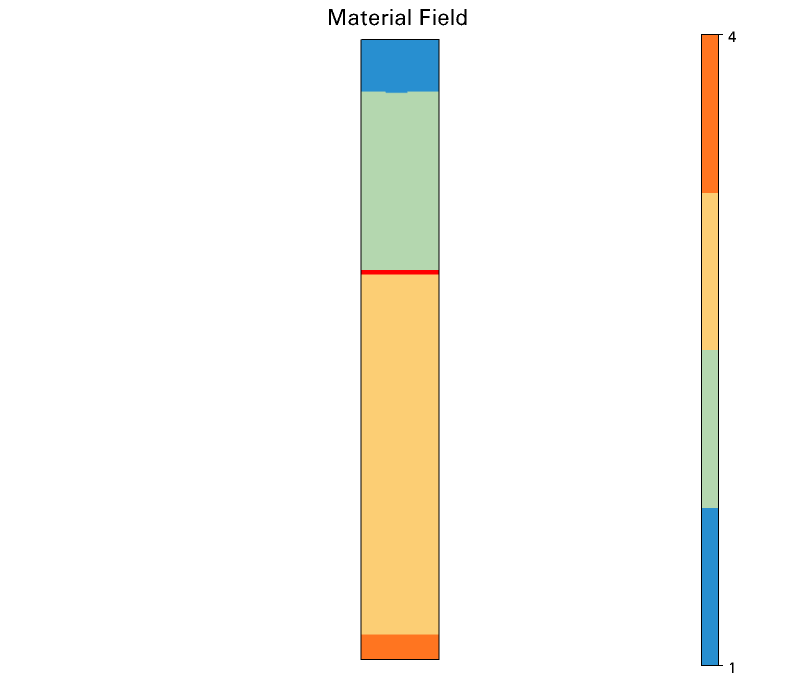

In [16]:
Fig = vis.Figure(figsize=(800,700), title="Material Field", quality=2)
surf = Fig.Surface(Model.mesh, Model.projMaterialField, fn_size=2.0, discrete=True, onMesh=False,resolution=500)
surf.colourBar["align"] = "right"
surf.colourBar["position"] = 0.
surf.colourBar["size"] = [0.9,0.02]
Fig.Contours(Model.mesh, 
             Model.temperature, 
             interval=GEO.nd(716.* u.degK),
             limits=(GEO.nd(716.*u.degK),
                     GEO.nd(800.*u.degK)),
             colourBar=False, colours="red",
             linewidth=5.0)
Fig.show()

In [17]:
GEO.rcParams["initial.nonlinear.tolerance"]=1e-2
GEO.rcParams["advection.diffusion.method"] = "SLCN"

In [18]:
Model.solver.set_inner_method("mumps")
Model.solver.set_penalty(1e6)

In [19]:
Model.run_for(1.0*u.megayear)

Running with UWGeodynamics version 2.8.1-dev-efa530e(development)
Options:  -force_correction True -pc_type none -Q22_pc_type gkgdiag -change_A11rhspresolve False -rescale_equations False -ksp_type bsscr -restore_K False -ksp_k2_type NULL -remove_constant_pressure_null_space False -change_backsolve False -A11_pc_factor_mat_solver_package mumps -A11_pc_type lu -A11_ksp_type preonly -scr_ksp_rtol 1e-05 -scr_ksp_type fgmres -A11_mg_active False


/usr/local/underworld2/lib/underworld/systems/_advectiondiffusion.py:80: UserWarning: 'phiDotField' doesn't influence the 'SLCN' method. It's only required for the 'SUPG' method
  " It's only required for the 'SUPG' method")


Step:     1 Model Time: 7797.2 year dt: 7797.2 year (2019-08-13 00:05:15)
Step:     2 Model Time: 16894.6 year dt: 9097.4 year (2019-08-13 00:05:16)
Step:     3 Model Time: 25993.4 year dt: 9098.7 year (2019-08-13 00:05:16)
Step:     4 Model Time: 35088.1 year dt: 9094.8 year (2019-08-13 00:05:17)
Step:     5 Model Time: 44189.4 year dt: 9101.3 year (2019-08-13 00:05:18)
Step:     6 Model Time: 53290.0 year dt: 9100.6 year (2019-08-13 00:05:19)
Step:     7 Model Time: 62399.3 year dt: 9109.2 year (2019-08-13 00:05:19)
Step:     8 Model Time: 71501.2 year dt: 9101.9 year (2019-08-13 00:05:20)
Step:     9 Model Time: 80603.5 year dt: 9102.3 year (2019-08-13 00:05:21)
Step:    10 Model Time: 89713.0 year dt: 9109.4 year (2019-08-13 00:05:21)
Step:    11 Model Time: 98824.6 year dt: 9111.7 year (2019-08-13 00:05:22)
Step:    12 Model Time: 107937.2 year dt: 9112.6 year (2019-08-13 00:05:23)
Step:    13 Model Time: 117048.8 year dt: 9111.5 year (2019-08-13 00:05:24)
Step:    14 Model Time: 

Step:   109 Model Time: 994021.9 year dt: 9157.7 year (2019-08-13 00:06:37)
Step:   110 Model Time: 1.0 megayear dt: 5978.1 year (2019-08-13 00:06:38)


1

# Plot Material Field and Isotherm


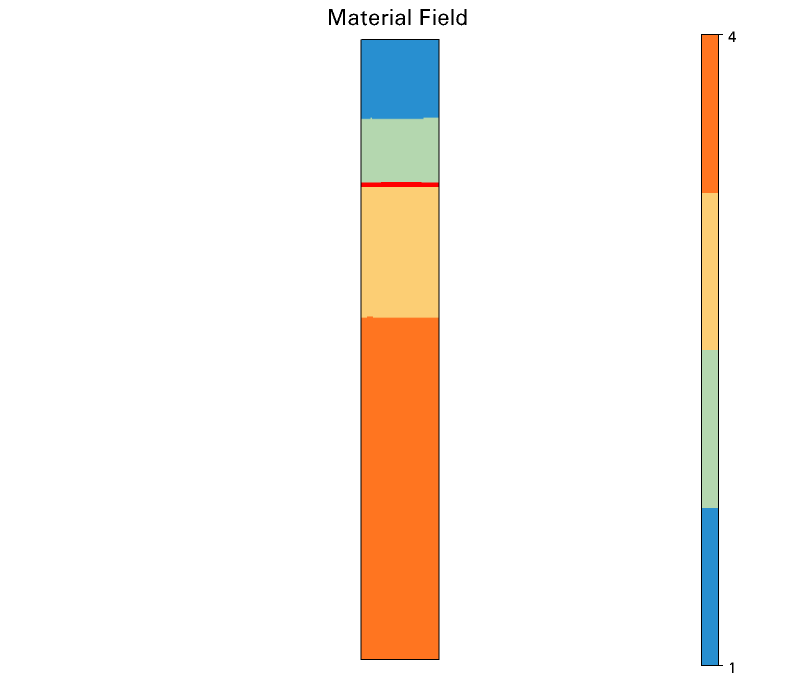

In [20]:
Fig = vis.Figure(figsize=(800,700), title="Material Field", quality=2)
surf = Fig.Surface(Model.mesh, Model.projMaterialField, fn_size=2.0, discrete=True, onMesh=False,resolution=500)
surf.colourBar["align"] = "right"
surf.colourBar["position"] = 0.
surf.colourBar["size"] = [0.9,0.02]
Fig.Contours(Model.mesh, 
             Model.temperature, 
             interval=GEO.nd(716.* u.degK),
             limits=(GEO.nd(716.*u.degK),
                     GEO.nd(800.*u.degK)),
             colourBar=False, colours="red",
             linewidth=5.0)
Fig.show()